In [1]:
RUN_VALID = True
RUN_TEST  = True

import torch
if not torch.cuda.is_available() or torch.cuda.device_count() < 2:
    raise RuntimeError("Requires >= 2 GPUs with CUDA enabled.")

try: 
    import monai
except: 
    !pip install --no-deps monai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.8 MB/s eta 0:00:00


# Caformer Improved Notebook

This is the final notebook I will release in this competition. I recommend reading the previous notebooks, as many components are reused.

1. [HGNet-V2 - Starter](https://www.kaggle.com/code/brendanartley/hgnet-v2-starter)
2. [ConvNeXt - Full Resolution Baseline](https://www.kaggle.com/code/brendanartley/convnext-full-resolution-baseline)
3. [CAFormer - Full Resolution Improved](https://www.kaggle.com/code/brendanartley/caformer-full-resolution-improved)


This notebook features the strongest model I have found so far. A modified CAFormer encoder combined with an improved decoder (pixel shuffle, intermediate convolutions, and SCSE blocks).

Like previous notebooks, I provide a pre-trained model checkpoint (trained for 150 epochs) which achieved a validation MAE of ~24.

In [2]:
%%writefile _cfg.py

from types import SimpleNamespace
import torch

cfg= SimpleNamespace()
cfg.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg.local_rank = 0
cfg.seed = 123
cfg.subsample = None

cfg.backbone = "caformer_b36.sail_in22k_ft_in1k"
cfg.batch_size_val = 16

Writing _cfg.py


# Scheduler

I have removed the training loop from this notebook, though it is the same as previous notebooks. 

The only difference was the use of a custom learning rate scheduler. The scheduler uses a constant learning rate followed by a cosine annealing learning rate. It seems that a learning rate of 1e-4 works well at the beggining, but a lower learning rate is required to achieve lower training and validation MAE.

In [3]:
import math

from torch.optim.lr_scheduler import _LRScheduler

class ConstantCosineLR(_LRScheduler):
    """
    Constant learning rate followed by CosineAnnealing.
    """
    def __init__(
        self, 
        optimizer,
        total_steps, 
        pct_cosine, 
        last_epoch=-1,
        ):
        self.total_steps = total_steps
        self.milestone = int(total_steps * (1 - pct_cosine))
        self.cosine_steps = max(total_steps - self.milestone, 1)
        self.min_lr = 0
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        if step <= self.milestone:
            factor = 1.0
        else:
            s = step - self.milestone
            factor = 0.5 * (1 + math.cos(math.pi * s / self.cosine_steps))
        return [lr * factor for lr in self.base_lrs]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


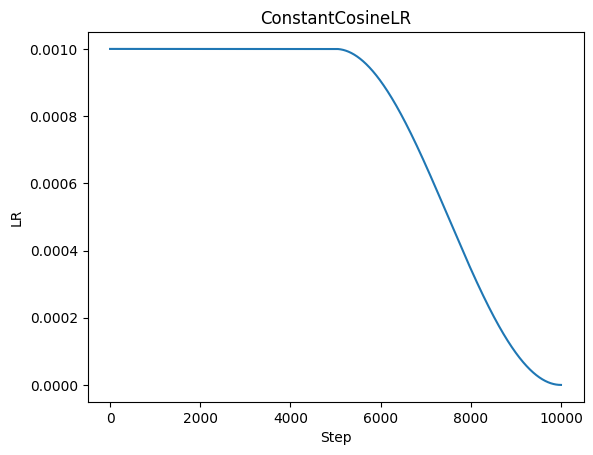

In [4]:
import torch
import matplotlib.pyplot as plt

# Dummy model
n_steps = 10_000
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Scheduler
scheduler = ConstantCosineLR(optimizer, total_steps=n_steps, pct_cosine=0.5)

# Get LRs
arr = []
for _ in range(n_steps):
    scheduler.step()
    arr.append(optimizer.param_groups[0]['lr'])

plt.plot(arr)
plt.xlabel("Step")
plt.ylabel("LR")
plt.title("ConstantCosineLR")
plt.show()


### Dataset

Same as previous notebook. 

In [5]:
%%writefile _dataset.py

import os
import glob

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        cfg,
        mode = "train", 
    ):
        self.cfg = cfg
        self.mode = mode
        
        self.data, self.labels, self.records = self.load_metadata()

    def load_metadata(self, ):

        # Select rows
        df= pd.read_csv("/kaggle/input/openfwi-preprocessed-72x72/folds.csv")
        if self.cfg.subsample is not None:
            df= df.groupby(["dataset", "fold"]).head(self.cfg.subsample)

        if self.mode == "train":
            df= df[df["fold"] != 0]
        else:
            df= df[df["fold"] == 0]

        
        data = []
        labels = []
        records = []
        mmap_mode = "r"

        for idx, row in tqdm(df.iterrows(), total=len(df), disable=self.cfg.local_rank != 0):
            row= row.to_dict()

            # Hacky way to get exact file name
            p1 = os.path.join("/kaggle/input/open-wfi-1/openfwi_float16_1/", row["data_fpath"])
            p2 = os.path.join("/kaggle/input/open-wfi-1/openfwi_float16_1/", row["data_fpath"].split("/")[0], "*", row["data_fpath"].split("/")[-1])
            p3 = os.path.join("/kaggle/input/open-wfi-2/openfwi_float16_2/", row["data_fpath"])
            p4 = os.path.join("/kaggle/input/open-wfi-2/openfwi_float16_2/", row["data_fpath"].split("/")[0], "*", row["data_fpath"].split("/")[-1])
            farr= glob.glob(p1) + glob.glob(p2) + glob.glob(p3) + glob.glob(p4)
        
            # Map to lbl fpath
            farr= farr[0]
            flbl= farr.replace('seis', 'vel').replace('data', 'model')
            
            # Load
            arr= np.load(farr, mmap_mode=mmap_mode)
            lbl= np.load(flbl, mmap_mode=mmap_mode)

            # Append
            data.append(arr)
            labels.append(lbl)
            records.append(row["dataset"])

        return data, labels, records

    def __getitem__(self, idx):
        row_idx= idx // 500
        col_idx= idx % 500

        d= self.records[row_idx]
        x= self.data[row_idx][col_idx, ...]
        y= self.labels[row_idx][col_idx, ...]

        # Augs 
        if self.mode == "train":
            
            # Temporal flip
            if np.random.random() < 0.5:
                x= x[::-1, :, ::-1]
                y= y[..., ::-1]

        x= x.copy()
        y= y.copy()
        
        return x, y

    def __len__(self, ):
        return len(self.records) * 500

Writing _dataset.py


# Model

This time we use the `CAFormer` backbone from timm. See more info on this backbone [here](https://huggingface.co/timm/caformer_b36.sail_in22k_ft_in1k) and the original paper [here](https://arxiv.org/abs/2210.13452).


### Encoder

Like with Convnext, we modify the encoder so that the feature maps are aligned with the target output shape. I think there is room for improvement at the `nn.ReflectionPad2d` step. Currently, the model uses lots of padding here and I am afraid the detail in the shallowest feature map is lacking.

### Decoder

The biggest changes in this notebook are to the decoder. 

First, we use PixelShuffle for upsampling. Pixelshuffle typically works well when fine detail is important, though it is more computatially expensive. Second, we add SCSE blocks. These are commonly used to increase decoder capacity with a minimal increase in parameter count and runtime. Finally, we add intermediate convolutions between the encoder output and decoder blocks. I beleive this trick was first introduced on Kaggle in the 3rd place solution of the Contrails Competition [here](https://www.kaggle.com/competitions/google-research-identify-contrails-redu), and also increases decoder capacity.

In [6]:
from copy import deepcopy
from types import MethodType

import torch
import torch.nn as nn
import torch.nn.functional as F

import timm

from monai.networks.blocks import UpSample, SubpixelUpsample

####################
## EMA + Ensemble ##
####################

class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.99, device=None):
        super().__init__()
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)


class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models).eval()

    def forward(self, x):
        output = None
        
        for m in self.models:
            logits= m(x)
            
            if output is None:
                output = logits
            else:
                output += logits
                
        output /= len(self.models)
        return output
        

#############
## Decoder ##
#############

class ConvBnAct2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding: int = 0,
        stride: int = 1,
        norm_layer: nn.Module = nn.Identity,
        act_layer: nn.Module = nn.ReLU,
    ):
        super().__init__()

        self.conv= nn.Conv2d(
            in_channels, 
            out_channels,
            kernel_size,
            stride=stride, 
            padding=padding, 
            bias=False,
        )
        self.norm = norm_layer(out_channels) if norm_layer != nn.Identity else nn.Identity()
        self.act= act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class SCSEModule2d(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.Tanh(),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels, 1, 1), 
            nn.Sigmoid(),
            )

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class Attention2d(nn.Module):
    def __init__(self, name, **params):
        super().__init__()
        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule2d(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

class DecoderBlock2d(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
        scale_factor: int = 2,
    ):
        super().__init__()

        # Upsample block
        if upsample_mode == "pixelshuffle":
            self.upsample= SubpixelUpsample(
                spatial_dims= 2,
                in_channels= in_channels,
                scale_factor= scale_factor,
            )
        else:
            self.upsample = UpSample(
                spatial_dims= 2,
                in_channels= in_channels,
                out_channels= in_channels,
                scale_factor= scale_factor,
                mode= upsample_mode,
            )

        if intermediate_conv:
            k= 3
            c= skip_channels if skip_channels != 0 else in_channels
            self.intermediate_conv = nn.Sequential(
                ConvBnAct2d(c, c, k, k//2),
                ConvBnAct2d(c, c, k, k//2),
                )
        else:
            self.intermediate_conv= None

        self.attention1 = Attention2d(
            name= attention_type, 
            in_channels= in_channels + skip_channels,
            )

        self.conv1 = ConvBnAct2d(
            in_channels + skip_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )

        self.conv2 = ConvBnAct2d(
            out_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )
        self.attention2 = Attention2d(
            name= attention_type, 
            in_channels= out_channels,
            )

    def forward(self, x, skip=None):
        x = self.upsample(x)

        if self.intermediate_conv is not None:
            if skip is not None:
                skip = self.intermediate_conv(skip)
            else:
                x = self.intermediate_conv(x)

        if skip is not None:
            # print(x.shape, skip.shape)
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class UnetDecoder2d(nn.Module):
    """
    Unet decoder.
    Source: https://arxiv.org/abs/1505.04597
    """
    def __init__(
        self,
        encoder_channels: tuple[int],
        skip_channels: tuple[int] = None,
        decoder_channels: tuple = (256, 128, 64, 32),
        scale_factors: tuple = (2,2,2,2),
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = "scse",
        intermediate_conv: bool = True,
        upsample_mode: str = "pixelshuffle",
    ):
        super().__init__()
        
        if len(encoder_channels) == 4:
            decoder_channels= decoder_channels[1:]
        self.decoder_channels= decoder_channels
        
        if skip_channels is None:
            skip_channels= list(encoder_channels[1:]) + [0]

        # Build decoder blocks
        in_channels= [encoder_channels[0]] + list(decoder_channels[:-1])
        self.blocks = nn.ModuleList()

        for i, (ic, sc, dc) in enumerate(zip(in_channels, skip_channels, decoder_channels)):
            # print(i, ic, sc, dc)
            self.blocks.append(
                DecoderBlock2d(
                    ic, sc, dc, 
                    norm_layer= norm_layer,
                    attention_type= attention_type,
                    intermediate_conv= intermediate_conv,
                    upsample_mode= upsample_mode,
                    scale_factor= scale_factors[i],
                    )
            )

    def forward(self, feats: list[torch.Tensor]):
        res= [feats[0]]
        feats= feats[1:]

        # Decoder blocks
        for i, b in enumerate(self.blocks):
            skip= feats[i] if i < len(feats) else None
            res.append(
                b(res[-1], skip=skip),
                )
            
        return res

class SegmentationHead2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        scale_factor: tuple[int] = (2,2),
        kernel_size: int = 3,
        mode: str = "nontrainable",
    ):
        super().__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size= kernel_size,
            padding= kernel_size//2
        )
        self.upsample = UpSample(
            spatial_dims= 2,
            in_channels= out_channels,
            out_channels= out_channels,
            scale_factor= scale_factor,
            mode= mode,
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        return x
        

#############
## Encoder ##
#############

class Net(nn.Module):
    def __init__(
        self,
        backbone: str,
        pretrained: bool = True,
    ):
        super().__init__()
        
        # Encoder
        self.backbone= timm.create_model(
            backbone,
            in_chans= 5,
            pretrained= pretrained,
            features_only= True,
            drop_path_rate=0.0,
            )
        ecs= [_["num_chs"] for _ in self.backbone.feature_info][::-1]

        # Decoder
        self.decoder= UnetDecoder2d(
            encoder_channels= ecs,
        )

        self.seg_head= SegmentationHead2d(
            in_channels= self.decoder.decoder_channels[-1],
            out_channels= 1,
            scale_factor= 1,
        )
        
        self._update_stem(backbone)

    def _update_stem(self, backbone):
        m = self.backbone

        m.stem.conv.stride=(4,1)
        m.stem.conv.padding=(0,4)
        m.stages_0.downsample = nn.AvgPool2d(kernel_size=(4,1), stride=(4,1))
        m.stem= nn.Sequential(
            nn.ReflectionPad2d((0,0,78,78)),
            m.stem,
        )

        pass

        
    def proc_flip(self, x_in):
        x_in= torch.flip(x_in, dims=[-3, -1])
        x= self.backbone(x_in)
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= torch.flip(x_seg, dims=[-1])
        x_seg= x_seg * 1500 + 3000
        return x_seg

    def forward(self, batch):
        x= batch

        # Encoder
        x_in = x
        x= self.backbone(x)
        # print([_.shape for _ in x])
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        # print([_.shape for _ in x])
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= x_seg * 1500 + 3000
    
        if self.training:
            return x_seg
        else:
            p1 = self.proc_flip(x_in)
            x_seg = torch.mean(torch.stack([x_seg, p1]), dim=0)
            return x_seg

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-06-06 01:27:31.722709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749173252.113059      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749173252.228805      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Utils

Same as previous notebook. 

In [7]:
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Pretrained Model

Next, we load in the pretrained model. This model was trained with a batch size of 16 for 200 epochs.

In [8]:
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

from _cfg import cfg

if RUN_VALID or RUN_TEST:

    # Load pretrained models
    models = []
    for f in sorted(glob.glob("/kaggle/input/openfwi-preprocessed-72x72/models_1000x70/unet2d_caformer*.pt")):
        print("Loading: ", f)
        m = Net(
            backbone=cfg.backbone,
            pretrained=False,
        )
        state_dict= torch.load(f, map_location=cfg.device, weights_only=True)
        state_dict= {k.removeprefix("_orig_mod."):v for k,v in state_dict.items()} # Remove torch.compile() prefix

        m.load_state_dict(state_dict)
        models.append(m)
    
    # Combine
    model = EnsembleModel(models)
    model = model.to(cfg.device)
    model = model.eval()
    print("n_models: {:_}".format(len(models)))

Loading:  /kaggle/input/openfwi-preprocessed-72x72/models_1000x70/unet2d_caformer_seed3_epochbest.pt
n_models: 1


# Valid

Next, we score the ensemble on the validation set.

In [9]:
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
from torch.amp import autocast

from _dataset import CustomDataset


if RUN_VALID:

    # Dataset / Dataloader
    valid_ds = CustomDataset(cfg=cfg, mode="valid")
    sampler = torch.utils.data.SequentialSampler(valid_ds)
    valid_dl = torch.utils.data.DataLoader(
        valid_ds, 
        sampler= sampler,
        batch_size= cfg.batch_size_val, 
        num_workers= 4,
    )

    # Valid loop
    criterion = nn.L1Loss()
    val_logits = []
    val_targets = []
    
    with torch.no_grad():
        for x, y in tqdm(valid_dl):
            x = x.to(cfg.device)
            y = y.to(cfg.device)
    
            with autocast(cfg.device.type):
                out = model(x)
    
            val_logits.append(out.cpu())
            val_targets.append(y.cpu())
    
        val_logits= torch.cat(val_logits, dim=0)
        val_targets= torch.cat(val_targets, dim=0)
    
        total_loss= criterion(val_logits, val_targets).item()
    
    # Dataset Scores
    ds_idxs= np.array([valid_ds.records])
    ds_idxs= np.repeat(ds_idxs, repeats=500)
    
    print("="*25)
    with torch.no_grad():    
        for idx in sorted(np.unique(ds_idxs)):
    
            # Mask
            mask = ds_idxs == idx
            logits_ds = val_logits[mask]
            targets_ds = val_targets[mask]
    
            # Score predictions
            loss = criterion(val_logits[mask], val_targets[mask]).item()
            print("{:15} {:.2f}".format(idx, loss))
    print("="*25)
    print("Val MAE: {:.2f}".format(total_loss))
    print("="*25)

100%|██████████| 625/625 [06:27<00:00,  1.61it/s]


CurveFault_A    4.00
CurveFault_B    71.06
CurveVel_A      9.19
CurveVel_B      38.60
FlatFault_A     2.58
FlatFault_B     24.29
FlatVel_A       1.31
FlatVel_B       7.20
Style_A         34.34
Style_B         48.90
Val MAE: 24.15


# Test

Finally, we make predictions on the test data.

In [10]:
import torch

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_files):
        self.test_files = test_files

    def __len__(self):
        return len(self.test_files)

    def __getitem__(self, i):
        test_file = self.test_files[i]
        test_stem = test_file.split("/")[-1].split(".")[0]
        return np.load(test_file), test_stem

In [11]:
import csv
import time
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd


if RUN_TEST:

    ss= pd.read_csv("/kaggle/input/waveform-inversion/sample_submission.csv")    
    row_count = 0
    t0 = time.time()
    
    test_files = sorted(glob.glob("/kaggle/input/open-wfi-test/test/*.npy"))
    x_cols = [f"x_{i}" for i in range(1, 70, 2)]
    fieldnames = ["oid_ypos"] + x_cols
    
    test_ds = TestDataset(test_files)
    test_dl = torch.utils.data.DataLoader(
        test_ds, 
        sampler=torch.utils.data.SequentialSampler(test_ds),
        batch_size=cfg.batch_size_val, 
        num_workers=4,
    )
    
    with open("submission.csv", "wt", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        with torch.inference_mode():
            with torch.autocast(cfg.device.type):
                for inputs, oids_test in tqdm(test_dl, total=len(test_dl)):
                    inputs = inputs.to(cfg.device)
            
                    outputs = model(inputs)
                            
                    y_preds = outputs[:, 0].cpu().numpy()
                    
                    for y_pred, oid_test in zip(y_preds, oids_test):
                        for y_pos in range(70):
                            row = dict(zip(x_cols, [y_pred[y_pos, x_pos] for x_pos in range(1, 70, 2)]))
                            row["oid_ypos"] = f"{oid_test}_y_{y_pos}"
            
                            writer.writerow(row)
                            row_count += 1

                            # Clear buffer
                            if row_count % 100_000 == 0:
                                csvfile.flush()
    
    t1 = format_time(time.time() - t0)
    print(f"Inference Time: {t1}")

100%|██████████| 4114/4114 [44:38<00:00,  1.54it/s]

Inference Time: 0:44:40


We can also view a few samples to make sure things look reasonable.

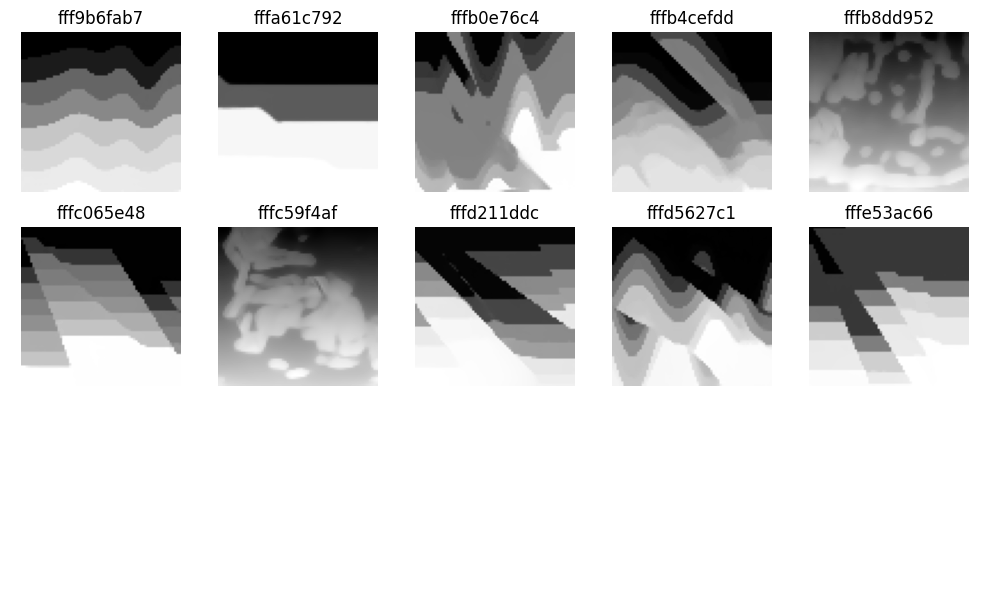

In [12]:
import matplotlib.pyplot as plt 

if RUN_TEST:
    # Plot a few samples
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    axes= axes.flatten()

    n = min(len(outputs), len(axes))
    
    for i in range(n):
        img= outputs[0, 0, ...].cpu().numpy()
        img = outputs[i, 0].cpu().numpy()
        idx= oids_test[i]
    
        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(idx)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()